We wish to show that a steady state invariant extended kalman filter on the lie group SO3 has a set that is invariant and attractive given that the disturbance is bounded.

This will allow us to simplify verification of the autopilot.

$
\renewcommand{vec}[1]{\boldsymbol{#1}}
\renewcommand{lieWedge}[1]{\left[{#1}\right]^{\wedge}}
\renewcommand{lieVee}[1]{\left[{#1}\right]^{\vee}}
\renewcommand{lieExp}[1]{\exp^{\wedge}\left({#1}\right)}
\renewcommand{lieLog}[1]{\log^{\vee}\left({#1}\right)}
\begin{align}
E &:= \hat{X} X^{-1} \\
\dot{\hat{X}} &= \hat{X} \lieWedge{\vec{\omega} + \vec{w}} \\
\dot{X} &= X [\vec{\omega}]^{\wedge} \\
\end{align}
$

$
\begin{align}
\dot{E} &= \dot{\hat{X}} X^{-1} - \hat{X} X^{-1} \dot{X} X^{-1} \\
&=  \hat{X} \lieWedge{\vec{\omega} + \vec{w}} X^{-1} - \hat{X} X^{-1}  X [\vec{\omega}]^{\wedge} X^{-1} \\
&= \hat{X} \lieWedge{\vec{w}} X^{-1}
\end{align}
$

$
\begin{align}
\lieWedge{\dot{\vec{e}}} &= \dot{E} E^{-1} = \hat{X} \lieWedge{\vec{w}} X^{-1} X \hat{X}^{-1}  = \hat{X} \lieWedge{\vec{w}} \hat{X}^{-1} = \lieWedge{\hat{X}  \vec{w}} \\
\dot{\vec{e}} &= {\hat{X} \vec{w}} \\
\end{align}
$

$
\begin{align}
Y &= X \\
\hat{Y} &= \lieExp{\vec{v}} \hat{X}\\
Z &:= \hat{Y}Y^{-1} = \lieExp{\vec{v}} E \\
\vec{e}_{+|+} &=  \lieExp{ K \lieLog{Z}} \vec{e}_{+|-}
\end{align}
$

In [1]:
import numpy as np
import scipy.linalg
import scipy.integrate
import scipy.signal
import matplotlib.pyplot as plt
import cvxpy as cvx
import control

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
def setup():
    def f(t, x, A, C, L, M, N, w, v):
        return (A - L.dot(C)).dot(x) + M.dot(w) - L.dot(N).dot(v)
    t0 = 0
    tf = 10
    dt = 0.01
    
    A = np.array([[0, 1], [-2, -1]])
    C = np.array([[0], [1]]).T
    N_w = 1
    N_v = 1
    Q = N_w*np.eye(2)
    R = N_v*np.eye(1)
    M = np.eye(2)
    N = np.eye(1)
    
    # discrete time
    F = scipy.linalg.expm(A*dt)
    Md = M*dt
    Nd = N*dt
    
    x0 = np.array([2, 1])
    w_freq = 1
        
    try:
        P = scipy.linalg.solve_continuous_are(A.T, C.T, Q, R)
        P_inv = scipy.linalg.inv(P)
        L = P.dot(C.T).dot(np.linalg.inv(R))
        A_o = A - L.dot(C)
        if not np.all(np.real(np.linalg.eig(A_o)[0]) < 0):
            raise RuntimeError('continuous observer not stable', np.linalg.eig(A_o)[0])
    except scipy.linalg.LinAlgError as e:
        print('continuous Kalman steady state gain computation failed', e)
        P = None
        P_inv = None
        L = None
    
    try:
        Pd = scipy.linalg.solve_discrete_are(F.T, C.T, Q, R)
        Pd_inv = scipy.linalg.inv(Pd)
        Ld = Pd.dot(C.T).dot(np.linalg.inv(R))
        F_o = F - L.dot(C)
        if not np.all(np.abs(np.linalg.eig(F_o)[0]) < 1):
            raise RuntimeError('discrete observer not stable', np.linalg.eig(F_o)[0])
    
    except scipy.linalg.LinAlgError as e:
        print('discrete Kalman steady state gain computation failed', e)
        Pd = None
        Pd_inv = None
        Ld = None
    
    #print('f test', f(0, x0, A, C, L, M, N, np.array([0, 0]), np.array([0])))

    return locals()
params = setup()

In [7]:
def sim(params):    
    t0 = params['t0']
    tf = params['tf']
    dt = params['dt']

    x0 = params['x0']
    dt = params['dt']
    f = params['f']
    w_freq = params['w_freq']

    A=params['A']
    C=params['C']
    L=params['L']
    M=params['M']
    N=params['N']

    data = {
        't': [t0],
        'x': [x0],
        'w': [np.array([0, 0])],
        'v': [0]
    }
    
    t_eval = np.arange(t0, tf, dt)
    for i in range(len(t_eval) - 1):
        t0 = t_eval[i]
        tf = t_eval[i + 1]
        w= M.dot(np.array([scipy.signal.square(2*np.pi*w_freq*t0),
                    scipy.signal.square(2*np.pi*w_freq*t0 + 1)])/np.sqrt(2))
        v= N.dot(np.array([scipy.signal.square(2*np.pi*w_freq*t0)]))
        res = scipy.integrate.solve_ivp(
            lambda t, x, A=A, C=C, L=L, M=M, N=N: params['f'](
                t=t, x=x, A=A, C=C, L=L, M=M, N=N,
                w=w, v=v),
            t_span=[t0, tf], y0=x0, t_eval=[tf])
        ti = res['t'][-1]
        xi = res['y'][:, -1]
        data['t'].append(ti)
        data['x'].append(xi.T)
        data['w'].append(w.T)
        data['v'].append(v.T)
        x0 = xi
    for k in data:
        data[k] = np.array(data[k])
    return data
sim(params);

$\dot{V} + V - \gamma ||w||^2 < 0$

Error Dynamics:

$
\begin{align}
\dot{x} &= A x + M w \\
& ||w||_\infty < 1 \\
y &= Cx + Nv\\
& ||v||_\infty < 1 \\
\hat{y} &= C\hat{x} \\
\dot{\hat{x}} &= A \hat{x} + L(y - \hat{y})  \\
& = A \hat{x} + LC e + LN v \\
e &:= x - \hat{x} \\
\dot{e} &:= (A - LC) e + M w - LN v \\
\end{align}
$

Lyapunov Function

$
\begin{align}
V &:= e^T P e \\
A_o &:= A - LC \\
\dot{V} &= \dot{e}^T P e + e^T P \dot{e} \\
&= (e^TA_o^T + w^TM^T - v^TN^TL^T)P e + e^T P (A_o e + Mw - LNv) \\
 &= e^T(A_o^TP + PA_o)e + w^TM^TPe - v^TN^TL^TPe + e^T P Mw - e^TP LNv
\end{align}
$

If we can use an LMI to solve:

$ \dot{V} + V - \gamma_w||w||^2 -  \gamma_v||v||^2 < 0 $

for $P$, $\gamma_w$, $\gamma_v$, Then using the inequality, if
$V > \gamma_w||w||^2 + \gamma_v||v||^2$ then $\dot{V} < 0$.

Therefore $V <= \gamma_w||w||^2 +  \gamma_v||v||^2$, is an attractive and invariant set.

The LMI can be constructed as follows:

miminimize: $\gamma_v + \gamma_w$

subject to the constraints:

$
\begin{align}
\begin{pmatrix}
A_o^TP + PA_o + P & PM & - PLN \\
M^TP & -\gamma_w I & 0 \\
-N^TL^TP & 0 & -\gamma_v I
\end{pmatrix} &< 0 \\
P &> 0
\end{align}
$

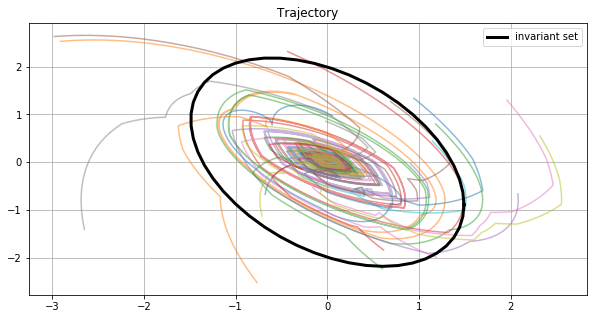

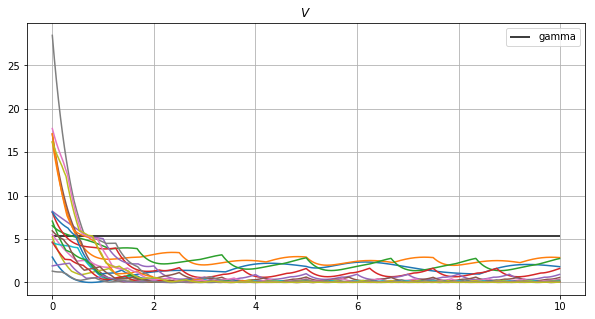

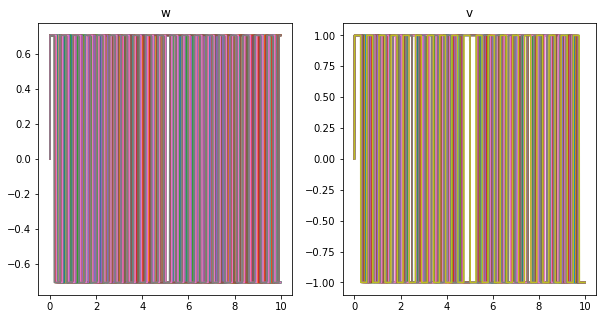

In [8]:
def test_continuous(params):
    A = params['A']
    C = params['C']
    L = params['L']
    M = params['M']
    N = params['N']
    
    nx = A.shape[0]
    nw = M.shape[0]
    nv = N.shape[0]

    alpha = 0 # set higher to garuntee exponential convergence at alpha
    
    P = cvx.Variable(name='P', shape=A.shape, PSD=True)
    gamma_w = cvx.Variable(name='gamma_w', nonneg=True)
    gamma_v = cvx.Variable(name='gamma_v', nonneg=True)
    prob = cvx.Problem(cvx.Minimize(gamma_w + gamma_v), [
        P >> np.eye(2),
        cvx.bmat([
            [(A - L*C).T*P + P*(A - L*C) + (1 + alpha)*P, P*M, -P*L*N],
            [M.T*P, -gamma_w*np.eye(nw), np.zeros((nw, nv))],
            [-N.T*L.T*P, np.zeros((nv, nw)), -gamma_v*np.eye(nv)]
        ]) << 0
        ])
    prob.solve(verbose=False, eps=1e-5)
    if not prob.status == 'optimal':
        raise RuntimeError('optim failed', prob.status)

    gamma = gamma_w.value + gamma_v.value
    
    data_list = []
    for w_freq in np.arange(0.1, 2, 0.1):
        params['x0'] = 3*(2*np.random.rand(2) - 1)
        params['w_freq'] = w_freq
        data = sim(params)
        V = []
        V_kf = []
        for i in range(len(data['t'])):
            xi = data['x'][i, :]
            V.append(xi.T.dot(P.value).dot(xi))
            V_kf.append(xi.T.dot(params['P_inv']).dot(xi))
        V = np.array(V)
        V_kf = np.array(V_kf)
        data['V'] = V
        data['V_kf'] = V_kf
        data_list.append(data)

    plt.figure(figsize=(10, 5))
    for data  in data_list:
        plt.plot(data['x'][:, 0], data['x'][:, 1], alpha=0.5)
    theta = np.linspace(0, 2*np.pi)
    R = np.linalg.cholesky(P.value)
    y = np.sqrt(gamma)*np.array([np.cos(theta), np.sin(theta)])
    x = np.linalg.inv(R).dot(y)
    plt.plot(x[0,:], x[1, :], linewidth=3, color='k', label='invariant set')
    plt.legend()
    plt.grid()
    plt.title('Trajectory')

    t = data['t']
    
    plt.figure(figsize=(10, 5))
    for data in data_list:
        plt.plot(t, data['V'])
        
    plt.hlines(gamma, t[0], t[-1], label='gamma')
    plt.grid()
    plt.legend()
    plt.title('$V$')
    
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    for data in data_list:
        plt.plot(t, data['w'])
    plt.title('w')
    
    plt.subplot(122)
    for data in data_list:
        plt.plot(t, data['v'])
    plt.title('v')
    
    return locals()

params = setup()
res_cont = test_continuous(params)

## Discrete

There are some errors here due to the continuous time approximation. We can further improve by deriving it in discrete time.

$
\begin{align}
x_+ &= F x + Mw \\
\hat{x}_+ &= F \hat{x} + L(y - \hat{y})\\
e_+ &:= x_+ - \hat{x}_+ \\
F_o &:= F - LC \\
e_+ &= F_o e + Mw - LN v \\
V &:= e^T P e \\
\Delta V & := V_+ - V \\
&= e_+^T P e_+ - e^T P e \\
\Delta V  &= (e^T F_o^T + w^T M^T - v^T N^T L^T)P(F_o e + Mw - LN v ) - e^T P e \\
&= e^T(F_o^T P F_o - P) e + e^T F_o^T P Mw - e^T F_o^T P LN v \\
 & + w^TM^TPF_o e + w^TM^T P Mw - w^TM^TPLNv \\
 & - v^TN^TL^TPF_o e- v^TN^TL^TPMw + v^TN^TL^TPLNv \\
 &= \begin{pmatrix}x^T & w^T & v^T \end{pmatrix} \begin{pmatrix}
 F_o^T P F_o - P & F_o^TPM & -F_o^TPLN \\
 M^TPF_o & M^TPM & -M^TPLN \\
 -N^TL^TPF_o & -N^TL^TPM & N^TL^TPLN
 \end{pmatrix} \begin{pmatrix}x \\ w \\ v  \end{pmatrix} 
\end{align}
$

We wish to represent the following inequality:

$\Delta V + V - \gamma_w ||w||^2 - \gamma_v ||v||^2 < 0$

Which we can represent by the following LMI:

$
\begin{align}
\begin{pmatrix}
 F_o^T P F_o & F_o^TPM & -F_o^TPLN \\
 M^TPF_o & M^TPM - \gamma_w I & -M^TPLN \\
 -N^TL^TPF_o & -N^TL^TPM & N^TL^TPLN - \gamma_v I
 \end{pmatrix}  < 0
\end{align}
$

Which implies:

$\Delta V < 0$ when $V > \gamma_w ||w||^2 + \gamma_v ||v||^2$



In [11]:
def sim_discrete(params):    
    t0 = params['t0']
    tf = params['tf']
    dt = params['dt']

    x0 = params['x0']
    dt = params['dt']
    f = params['f']
    w_freq = params['w_freq']

    A=params['A']
    C=params['C']
    L=params['L']
    M=params['M']
    N=params['N']
    F_o=params['F_o']
    A_o=params['A_o']

    data = {
        't': [t0],
        'x': [x0],
        'w': [np.array([0, 0])],
        'v': [np.array([0])]
    }
    
    t_eval = np.arange(t0, tf, dt)
    x = x0
    print('F_o', F_o)
    for i in range(len(t_eval) - 1):
        t0 = t_eval[i]
        tf = t_eval[i + 1]
        w= M.dot(np.array([scipy.signal.square(2*np.pi*w_freq*t0),
                    scipy.signal.square(2*np.pi*w_freq*t0 + 1)])/np.sqrt(2))
        v= N.dot(np.array([scipy.signal.square(2*np.pi*w_freq*t0)]))
        x = np.dot(F_o, x) + np.dot(M, w)*dt - np.dot(np.dot(L, N), v)*dt

        data['t'].append(tf)
        data['x'].append(x.T)
        data['w'].append(w.T)
        data['v'].append(v.T)
    for k in data:
        data[k] = np.array(data[k])
    return data

optimal_inaccurate
F_o [[ 0.99990033  0.4241634 ]
 [-0.01989967  0.07766018]]
F_o [[ 0.99990033  0.4241634 ]
 [-0.01989967  0.07766018]]
F_o [[ 0.99990033  0.4241634 ]
 [-0.01989967  0.07766018]]
F_o [[ 0.99990033  0.4241634 ]
 [-0.01989967  0.07766018]]
F_o [[ 0.99990033  0.4241634 ]
 [-0.01989967  0.07766018]]
F_o [[ 0.99990033  0.4241634 ]
 [-0.01989967  0.07766018]]
F_o [[ 0.99990033  0.4241634 ]
 [-0.01989967  0.07766018]]
F_o [[ 0.99990033  0.4241634 ]
 [-0.01989967  0.07766018]]
F_o [[ 0.99990033  0.4241634 ]
 [-0.01989967  0.07766018]]


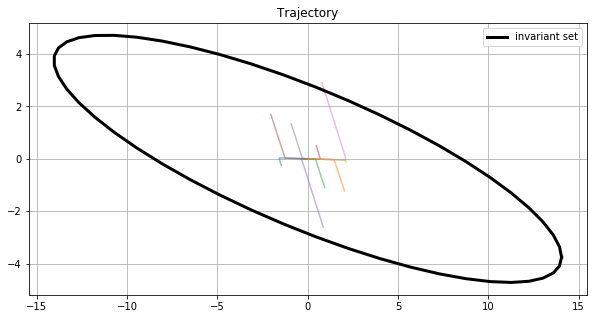

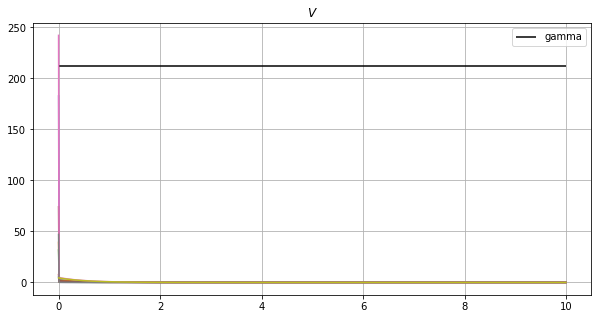

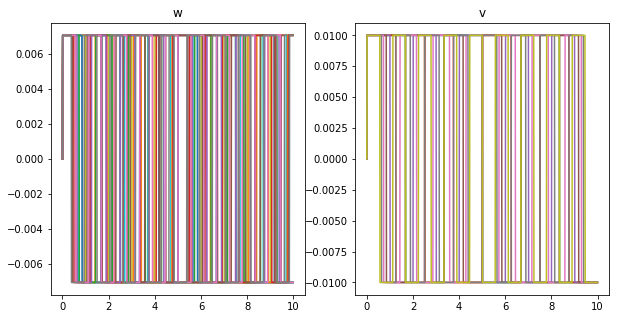

In [12]:
def test_discrete(params):
    A = params['A']
    C = params['C']
    L = params['Ld']
    M = params['M']
    N = params['N']
    F_o = params['F_o']
    dt = params['dt']
    
    nx = A.shape[0]
    nw = M.shape[0]
    nv = N.shape[0]
    
    M = M
    N = N
    
    alpha = 0 # set higher to garuntee exponential convergence at alpha
    
    P = cvx.Variable(name='P', shape=A.shape, PSD=True)
    gamma_w = cvx.Variable(name='gamma_w', nonneg=True)
    gamma_v = cvx.Variable(name='gamma_v', nonneg=True)
        
    prob = cvx.Problem(cvx.Minimize(gamma_w + gamma_v), [
        P >> np.eye(2),
        cvx.bmat([
            [F_o.T*P*F_o - P, F_o.T*P*M, -F_o.T*P*L*N],
            [M.T*P*F_o, M.T*P*M - gamma_w*np.eye(nw), -M.T*P*L*N],
            [-N.T*L.T*P*F_o, -N.T*L.T*P*M, N.T*L.T*P*L*N - gamma_v*np.eye(nv)]
        ]) << 0
    ])
        
    prob.solve(verbose=False, eps=1e-10)
    print(prob.status)
    #f not prob.status == 'optimal':
    #   raise RuntimeError('optim failed', prob.status)

    gamma = gamma_w.value + gamma_v.value
    
    data_list = []
    for w_freq in np.arange(0.1, 1, 0.1):
        sim_params = dict(params)
        sim_params['x0'] = 3*(2*np.random.rand(2) - 1)
        sim_params['w_freq'] = w_freq
        sim_params['M'] = M*dt
        sim_params['N'] = N*dt
        data = sim_discrete(sim_params)
        V = []
        V_kf = []
        for i in range(len(data['t'])):
            xi = data['x'][i, :]
            V.append(xi.T.dot(P.value).dot(xi))
            V_kf.append(xi.T.dot(params['Pd_inv']).dot(xi))
        V = np.array(V)
        V_kf = np.array(V_kf)
        data['V'] = V
        data['V_kf'] = V_kf
        data_list.append(data)

    plt.figure(figsize=(10, 5))
    for data  in data_list:
        plt.plot(data['x'][:, 0], data['x'][:, 1], alpha=0.5)
    theta = np.linspace(0, 2*np.pi)
    R = np.linalg.cholesky(P.value)
    y = np.sqrt(gamma)*np.array([np.cos(theta), np.sin(theta)])
    x = np.linalg.inv(R).dot(y)
    plt.plot(x[0,:], x[1, :], linewidth=3, color='k', label='invariant set')
    plt.legend()
    plt.grid()
    plt.title('Trajectory')

    t = data['t']
    
    plt.figure(figsize=(10, 5))
    for data in data_list:
        plt.plot(t, data['V'])
        
    plt.hlines(gamma, t[0], t[-1], label='gamma')
    plt.grid()
    plt.legend()
    plt.title('$V$')
    
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    for data in data_list:
        plt.plot(t, data['w'])
    plt.title('w')
    
    plt.subplot(122)
    for data in data_list:
        plt.plot(t, data['v'])
    plt.title('v')
    
    return locals()

params = setup()
res_disc = test_discrete(params)